In [1]:
!pip install transformers
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
!pip install opencv-python

In [3]:
!pip install pdf2image

In [4]:
!pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 67.1 MB/s eta 0:00:00


In [5]:
import fitz  # PyMuPDF
import torch
import cv2
import numpy as np
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import matplotlib.pyplot as plt

2025-07-15 22:32:09.704213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752618729.938432      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752618730.006419      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.23G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.23G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=False)
              (key): Linear(in_features=1024, out_features=1024, bias=False)
              (value): Linear(in_features=1024, out_features=1024, bias=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=1024, out_features=4096, bias=True)
    

In [7]:
def extract_lines_from_image(pil_image):
    img = np.array(pil_image)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel_width = max(20, img.shape[1] // 25)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_width, 5))
    dilated = cv2.dilate(binary, kernel, iterations=1)

    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    line_images = []

    for cnt in sorted(contours, key=lambda c: cv2.boundingRect(c)[1]):
        x, y, w, h = cv2.boundingRect(cnt)
        if h > 20 and w > 50:
            line = img[y:y + h, x:x + w]
            line_img = Image.fromarray(line).convert("RGB")
            line_images.append(line_img)

    return line_images


In [8]:
def preprocess_line_image(line_img):
    img = np.array(line_img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # CLAHE for local contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    contrast = clahe.apply(gray)

    # Denoise
    denoised = cv2.fastNlMeansDenoising(contrast, h=15)

    # Sharpen
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(denoised, -1, kernel)

    # Adaptive threshold
    binary = cv2.adaptiveThreshold(
        sharpened, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY_INV,
        15, 8
    )

    # Resize for OCR (4×)
    resized = cv2.resize(binary, (binary.shape[1]*4, binary.shape[0]*4))
    return Image.fromarray(resized).convert("RGB")


In [9]:
def run_ocr_on_page(pil_image, page_number):
    lines = extract_lines_from_image(pil_image)
    print(f"\n📄 Page {page_number} — Total Detected Lines: {len(lines)}")

    for i, line in enumerate(lines):
        processed = preprocess_line_image(line)

        pixel_values = processor(images=processed, return_tensors="pt").pixel_values.to(device)
        generated_ids = model.generate(pixel_values, max_length=512)
        text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        # Filter gibberish lines
        if len(text.strip()) > 3 and any(c.isalpha() for c in text):
            print(f"🖋️ Line {i+1}: {text.strip()}")


In [10]:
pdf_path = "/kaggle/input/exam-paper/iot1 004.pdf"  # change this!
doc = fitz.open(pdf_path)

for i in range(len(doc)):
    page = doc[i]
    pix = page.get_pixmap(dpi=300)
    pil_img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    run_ocr_on_page(pil_img, i + 1)



📄 Page 1 — Total Detected Lines: 84
🖋️ Line 2: backbone of
🖋️ Line 3: as the
🖋️ Line 4: a cats .
🖋️ Line 5: Protocols .
🖋️ Line 6: I communication .
🖋️ Line 8: ( TDTS
🖋️ Line 9: networksInterface .
🖋️ Line 10: group of
🖋️ Line 11: dynamic .
🖋️ Line 12: is is
🖋️ Line 13: # NOT
🖋️ Line 16: is created .
🖋️ Line 17: " virtual space .
🖋️ Line 18: ( Where
🖋️ Line 20: interconnected .
🖋️ Line 21: communication of
🖋️ Line 22: data .
🖋️ Line 23: ' the
🖋️ Line 24: over an
🖋️ Line 25: corrected .
🖋️ Line 26: devices are
🖋️ Line 27: devices . The
🖋️ Line 29: is carried .
🖋️ Line 30: communication .
🖋️ Line 31: # Thees .
🖋️ Line 32: ( Internet .
🖋️ Line 33: in an Environment
🖋️ Line 34: each devices .
🖋️ Line 35: where .
🖋️ Line 36: I pautocols .
🖋️ Line 37: Scientificious ;
🖋️ Line 38: unique .
🖋️ Line 39: 6 ft.
🖋️ Line 41: whether .
🖋️ Line 42: will ensure .
🖋️ Line 43: Protocols .
🖋️ Line 44: 1st Communication .
🖋️ Line 45: corrected Interlinked air on
🖋️ Line 46: are .
🖋️ Line 47: devices .
🖋️

In [11]:
!pip install pymupdf transformers opencv-python pyspellchecker --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 57.7 MB/s eta 0:00:00


In [12]:
import fitz  # PyMuPDF
import cv2
import numpy as np
from PIL import Image
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from spellchecker import SpellChecker


In [13]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

spell = SpellChecker()


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
def preprocess_line_image(line_img):
    img = np.array(line_img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    contrast = clahe.apply(gray)

    # Denoise
    denoised = cv2.fastNlMeansDenoising(contrast, h=15)

    # Sharpen
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(denoised, -1, kernel)

    # Adaptive thresholding
    binary = cv2.adaptiveThreshold(sharpened, 255,
                                   cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, 15, 8)

    # Resize (4x)
    resized = cv2.resize(binary, (binary.shape[1]*4, binary.shape[0]*4))
    return Image.fromarray(resized).convert("RGB")


In [15]:
def extract_lines_from_image(pil_image):
    img = np.array(pil_image)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (img.shape[1]//25, 5))
    dilated = cv2.dilate(binary, kernel, iterations=1)

    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    lines = []

    for cnt in sorted(contours, key=lambda c: cv2.boundingRect(c)[1]):
        x, y, w, h = cv2.boundingRect(cnt)
        if h > 20 and w > 50:
            cropped = img[y:y+h, x:x+w]
            lines.append(Image.fromarray(cropped).convert("RGB"))
    return lines


In [16]:
def correct_spelling(text):
    words = text.split()
    corrected = [
        spell.correction(word) if spell.correction(word) is not None else word
        for word in words
    ]
    return ' '.join(corrected)

def run_ocr_on_page(pil_image, page_num):
    lines = extract_lines_from_image(pil_image)
    print(f"\n📄 Page {page_num} - Total Lines: {len(lines)}")

    for i, line in enumerate(lines):
        processed = preprocess_line_image(line)
        pixel_values = processor(images=processed, return_tensors="pt").pixel_values.to(device)
        generated_ids = model.generate(pixel_values, max_length=512)
        text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

        if len(text) > 3 and any(c.isalpha() for c in text):
            corrected = correct_spelling(text)
            print(f"🖋️ Line {i+1}: {corrected}")


In [17]:
pdf_path = "/kaggle/input/exam-paper/iot1 004.pdf"  # Change this
doc = fitz.open(pdf_path)

for i in range(len(doc)):
    page = doc[i]
    pix = page.get_pixmap(dpi=300)
    pil_img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    run_ocr_on_page(pil_img, i + 1)



📄 Page 1 - Total Lines: 84
🖋️ Line 2: backbone of
🖋️ Line 3: as the
🖋️ Line 4: a cats .
🖋️ Line 5: Protocols .
🖋️ Line 6: I communication .
🖋️ Line 8: ( tits
🖋️ Line 9: networksInterface .
🖋️ Line 10: group of
🖋️ Line 11: dynamic .
🖋️ Line 12: is is
🖋️ Line 13: # NOT
🖋️ Line 16: is created .
🖋️ Line 17: " virtual space .
🖋️ Line 18: ( Where
🖋️ Line 20: interconnected .
🖋️ Line 21: communication of
🖋️ Line 22: data .
🖋️ Line 23: ' the
🖋️ Line 24: over an
🖋️ Line 25: corrected .
🖋️ Line 26: devices are
🖋️ Line 27: devices . The
🖋️ Line 29: is carried .
🖋️ Line 30: communication .
🖋️ Line 31: # Thees .
🖋️ Line 32: ( Internet .
🖋️ Line 33: in an Environment
🖋️ Line 34: each devices .
🖋️ Line 35: where .
🖋️ Line 36: I protocols .
🖋️ Line 37: Scientificious ;
🖋️ Line 38: unique .
🖋️ Line 39: 6 to
🖋️ Line 41: whether .
🖋️ Line 42: will ensure .
🖋️ Line 43: Protocols .
🖋️ Line 44: st Communication .
🖋️ Line 45: corrected Interlinked air on
🖋️ Line 46: are .
🖋️ Line 47: devices .
🖋️ Line 48: p

In [18]:
import fitz  # PyMuPDF
from PIL import Image
import os

pdf_path = "/kaggle/input/exam-paper/iot1 004.pdf"
output_dir = "page_images"
os.makedirs(output_dir, exist_ok=True)

doc = fitz.open(pdf_path)

for i in range(len(doc)):
    page = doc[i]
    pix = page.get_pixmap(dpi=300)
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    img.save(f"{output_dir}/page_{i+1:03}.png")


In [19]:
import cv2
import numpy as np

def segment_lines_from_page(image_path, save_dir, page_num):
    os.makedirs(save_dir, exist_ok=True)
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold for binary image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Dilate horizontally to group lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(img.shape[1] * 0.8), 5))

    dilated = cv2.dilate(binary, kernel, iterations=1)

    # Find line contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    line_id = 1

    for cnt in sorted(contours, key=lambda c: cv2.boundingRect(c)[1]):
        x, y, w, h = cv2.boundingRect(cnt)
        if h > 20 and w > 50:  # ignore small noise
            cropped = img[y:y+h, x:x+w]
            out_path = os.path.join(save_dir, f"page{page_num:03}_line{line_id:03}.png")
            cv2.imwrite(out_path, cropped)
            line_id += 1


In [20]:
line_dir = "line_images"
os.makedirs(line_dir, exist_ok=True)

page_images = sorted(os.listdir("page_images"))

for i, filename in enumerate(page_images):
    path = os.path.join("page_images", filename)
    segment_lines_from_page(path, line_dir, i + 1)


In [21]:
import os

print("Total lines:", len(os.listdir("line_images")))
print(os.listdir("line_images")[:10])  # print a few


Total lines: 89
['page004_line008.png', 'page002_line015.png', 'page002_line011.png', 'page006_line011.png', 'page001_line001.png', 'page004_line016.png', 'page008_line003.png', 'page002_line010.png', 'page006_line014.png', 'page008_line008.png']


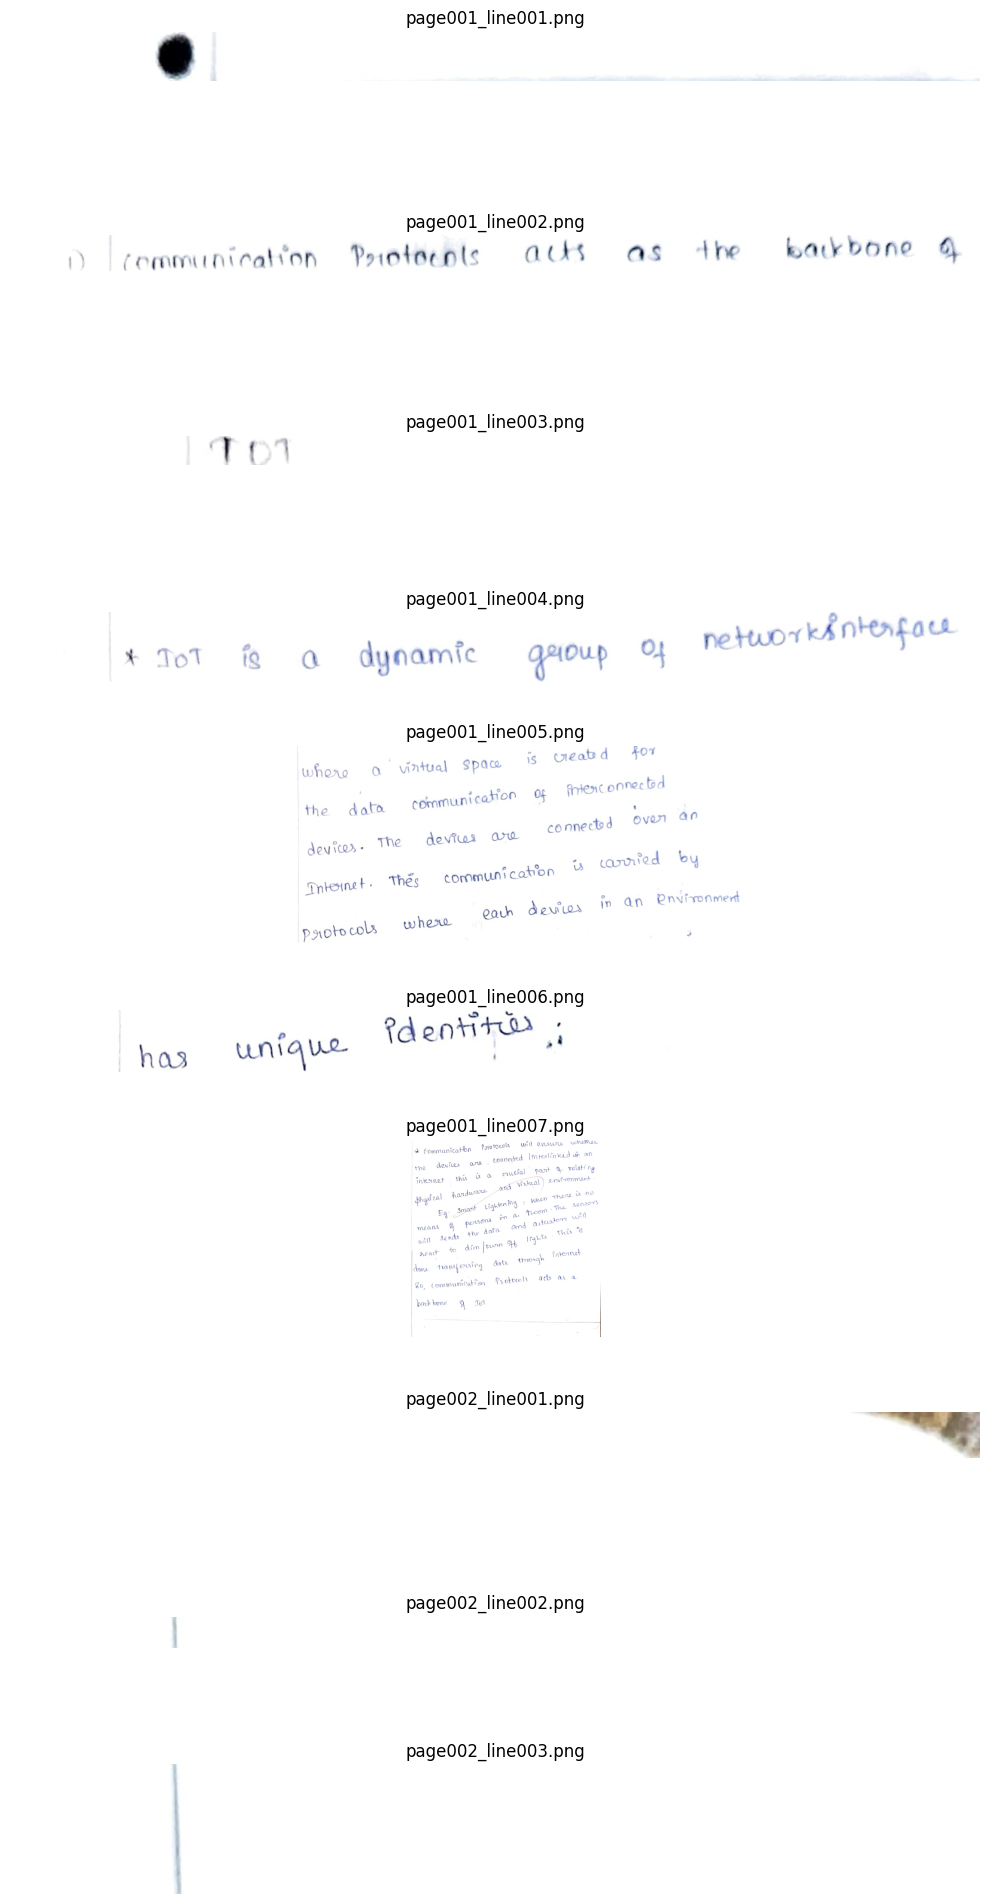

In [22]:
import matplotlib.pyplot as plt
import cv2
import os

folder = "line_images"
images = sorted(os.listdir(folder))[:10]  # show first 10

plt.figure(figsize=(10, 20))
for idx, img_name in enumerate(images):
    img = cv2.imread(os.path.join(folder, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(10, 1, idx + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_name)
plt.tight_layout()
plt.show()


In [23]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten").to(device)

line_dir = "line_images"
image_files = sorted(os.listdir(line_dir))

for i, file in enumerate(image_files):
    image = Image.open(os.path.join(line_dir, file)).convert("RGB")
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    print(f"📄 Line {i+1:03}: {text}")


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

📄 Line 001: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
📄 Line 002: a n. Communication Protobents acts as the backbone of
📄 Line 003: a b. What you know that it will be
📄 Line 004: # # # or it is a dynamic group of network-Interface
📄 Line 005: 0 0
📄 Line 006: # I has unique scientific ;
📄 Line 007: 0 0
📄 Line 008: 1961 62
📄 Line 009: 0 0
📄 Line 010: 0 0
📄 Line 011: a b c Blackpool
📄 Line 012: my characteristic of possible health respect
📄 Line 013: # the front of the
📄 Line 014: ( If I There are some significant characters
📄 Line 015: ( J. ) RESFUL AP. which makes them to
📄 Line 016: I standalone from other design interface
📄 Line 017: " If you . They are !
📄 Line 018: 0 1
📄 Line 019: stand are ready to access .
📄 Line 020: a b c d e f g. Fitzwilliam John eds Cottagas eds
📄 Line 021: as " you can design of ROTT physical design
📄 Line 022: 0 0000
📄 Line 023: 0 0
📄 Line 024: ' 76
📄 Line 025: 1961 1961 1962 1963
📄 Line 026: A ) EEST MOM architecture : ... "
📄 Line 027: 0 0
📄 Line 028: 0 0
📄 Line 029: 

In [24]:
def run_both_directions_ocr(image):
    normal = image
    flipped = image.transpose(Image.FLIP_LEFT_RIGHT)

    def get_text(pil_img):
        pixel_values = processor(images=pil_img, return_tensors="pt").pixel_values.to(device)
        ids = model.generate(pixel_values)
        return processor.batch_decode(ids, skip_special_tokens=True)[0]

    text_normal = get_text(normal)
    text_flipped = get_text(flipped)

    # Heuristic: choose the longer or more alphabetic one
    if sum(c.isalpha() for c in text_flipped) > sum(c.isalpha() for c in text_normal):
        return text_flipped
    return text_normal


In [25]:
!apt-get install -y poppler-utils





The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.8 [186 kB]
Fetched 186 kB in 2s (121 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 128663 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.8_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.8) ...
Setting up poppler-utils (22.02.0-2ubuntu0.8) ...
Processing triggers for man-db (2.10.2-1) ...


In [26]:
from pdf2image import convert_from_path
import os

pdf_path = "/kaggle/input/exam-paper/iot1 004.pdf"  # <- adjust to your file's actual path
output_folder = "page_images"
os.makedirs(output_folder, exist_ok=True)

# Convert the first page to image
pages = convert_from_path(pdf_path, dpi=300)
pages[0].save(os.path.join(output_folder, "page001.png"))

print("✅ PDF page converted to image successfully!")



✅ PDF page converted to image successfully!


In [27]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torch

In [28]:
# Load TR-OCR model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten").to(device)

# STEP 1 — Line segmentation from a single page image
def segment_lines_from_page(image_path, output_dir="line_images_page1", page_num=1):
    os.makedirs(output_dir, exist_ok=True)

    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Binary inverse + dilation to detect horizontal lines
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(img.shape[1] * 0.3), 5))

    dilated = cv2.dilate(binary, kernel, iterations=1)
# Step 1: Find contours after dilation
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# ✅ Step 2: Define and filter oversized contours
    filtered_contours = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if h < 150:  # You can tune this value
            filtered_contours.append(c)

    # Step 3: Sort top-to-bottom
    lines = sorted(filtered_contours, key=lambda c: cv2.boundingRect(c)[1])

    # Step 4: Save cropped line images
    for i, c in enumerate(lines):
      x, y, w, h = cv2.boundingRect(c)
      line_img = img[y:y + h, x:x + w]
      cv2.imwrite(os.path.join(output_dir, f"line_{i+1:03}.png"), line_img)
   

    print(f"✅ Extracted {len(lines)} line images from page {page_num}")

# STEP 2 — Preprocess each line image for better OCR
def preprocess_line_for_ocr(pil_image):
    image = np.array(pil_image)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # CLAHE contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # Resize
    resized = cv2.resize(enhanced, (1024, 256))

    # Convert single-channel grayscale back to 3-channel RGB
    rgb_resized = cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB)
    flipped_rgb = cv2.flip(rgb_resized, 1)

    return Image.fromarray(rgb_resized), Image.fromarray(flipped_rgb)
   



Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:




# STEP 3 — Smart OCR: Try both directions, pick better
def run_both_directions_ocr(image_normal, image_flipped):
    def get_text(pil_img):
        pixel_values = processor(images=pil_img, return_tensors="pt").pixel_values.to(device)
        ids = model.generate(pixel_values)
        return processor.batch_decode(ids, skip_special_tokens=True)[0]

    text_normal = get_text(image_normal)
    text_flipped = get_text(image_flipped)

    # Choose better (heuristic)
    if sum(c.isalpha() for c in text_flipped) > sum(c.isalpha() for c in text_normal):
        return text_flipped
    return text_normal

# STEP 4 — Run all steps on one page
page_image_path = "page_images/page001.png"  # Replace with your actual path
line_dir = "line_images_page1"

segment_lines_from_page(page_image_path, line_dir, page_num=1)

print("\n🧠 Extracting text from lines...\n")
image_files = sorted(os.listdir(line_dir))
seen_lines = set()  # 👈 Add this at the top


for i, filename in enumerate(image_files):
    image_path = os.path.join(line_dir, filename)
    image = Image.open(image_path).convert("RGB")

    pre_normal, pre_flipped = preprocess_line_for_ocr(image)
    text = run_both_directions_ocr(pre_normal, pre_flipped)
    if len(text.strip()) < 3 or sum(c.isalpha() for c in text) < 3:
        continue  # skip garbage lines

    if text.strip() in seen_lines:
        continue  # skip duplicate lines

    seen_lines.add(text.strip())

    if len(text.strip()) > 0:
        print(f"📄 Line {i+1:03}: {text}")
    else:
        print(f"📄 Line {i+1:03}: [EMPTY/NO TEXT]")


✅ Extracted 14 line images from page 1

🧠 Extracting text from lines...

📄 Line 002: What links hereRelated changesUpload fileSpecial pagesPermanent linkPage informationCite this pageWikid
📄 Line 003: a Communication Prototuous acts as the backbone of
📄 Line 004: a member of the People of the American Parliament of America
📄 Line 005: " It's not is a dynamic group of networks therefore
📄 Line 006: # not betrayed a scope , fountain to wearless
📄 Line 009: 1 . " in Kortitinski supinus and ,
📄 Line 010: satterly , even a kind electoral nothesinumming to


In [30]:
import matplotlib.pyplot as plt

def preview_segmented_lines(folder):
    images = sorted(os.listdir(folder))
    print(f"Total Segments: {len(images)}")

    for i, fname in enumerate(images):
        img_path = os.path.join(folder, fname)
        img = cv2.imread(img_path)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Line {i+1}")
        plt.axis('off')
        plt.show()


Total Segments: 14


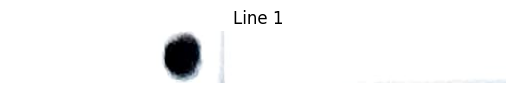

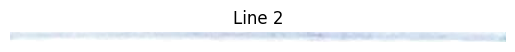

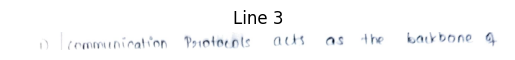

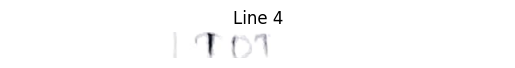

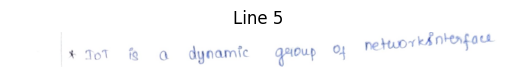

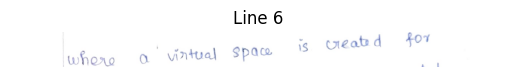

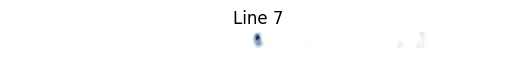

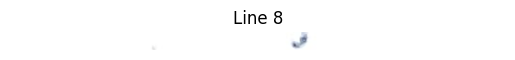

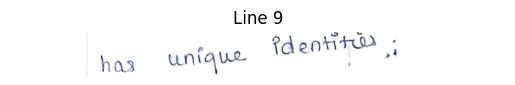

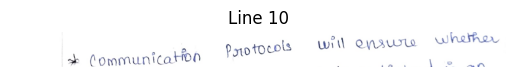

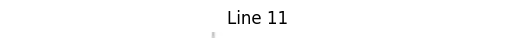

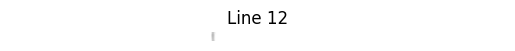

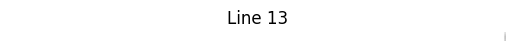

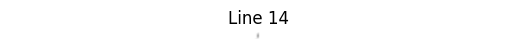

In [31]:
preview_segmented_lines("line_images_page1")


In [32]:
!mkdir -p output_folder
!cp -r line_images_page1 output_folder/
